# FastEMRIWaveforms Tutorial
## ICERM Workshop: Waveform acceleration with machine learning and GPUs

### Michael Katz, Max Planck Institute for Gravitational Physics (Albert Einstein Institute), Lead developer for FastEMRIWaveforms

In this tutorial, you will learn the basics of building an accelereated EMRI waveform. We encourage participants to see our paper ([arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071)) and the FastEMRIWaveforms [package documentation](https://bhptoolkit.org/FastEMRIWaveforms/) for more information, as well as our forthcoming paper that will describe the waveform in much more detail than our PRL submission. 

Import packages:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import h5py


from few.amplitude import romannet
from few.utils.utility import check_for_file_download, p_to_y
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux

Matplotlib is building the font cache; this may take a moment.


## A Quick Introduction to FastEMRIWaveforms

### Collaborators: Alvin Chua, Niels Warburton, Scott Hughes, Lorenzo Speri

/home/jotil/Tron/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.1.5-py3.7-linux-x86_64.egg/few/utils/utility.py:406: UserWarning: The file AmplitudeVectorNorm.dat did not open sucessfully. It will now be downloaded to the proper location.
  fp
/home/jotil/Tron/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.1.5-py3.7-linux-x86_64.egg/few/utils/utility.py:406: UserWarning: The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location.
  fp
/home/jotil/Tron/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.1.5-py3.7-linux-x86_64.egg/few/utils/utility.py:406: UserWarning: The file SchwarzschildEccentricInput.hdf5 did not open sucessfully. It will now be downloaded to the proper location.
  fp


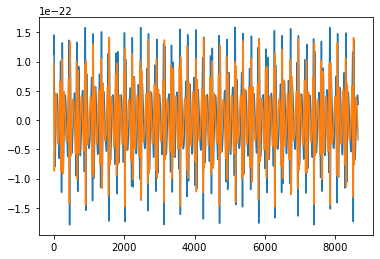

In [2]:
generate = FastSchwarzschildEccentricFlux()

M = 1e6  # large mass
mu = 1e1  # small mass
p0 = 12.0  # separation 
e0 = 0.4  # eccentricity
theta = np.pi/3.  # polar viewing angle
phi = np.pi/4.  # azimuthal viewing angle
dist = 1.0  # distance in Gpc

T = 1/365.  # in years
dt = 10.0  # time spacing of data stream

wave = generate(M, mu, p0, e0, theta, phi, dist, T=T, dt=dt)

plt.plot(wave.real)
plt.plot(wave.imag)

FastEMRIWaveforms is the first fully relativistic template generation tool for extreme mass ratio inspirals. We think of it more as a framework than any specific waveform. In this tutorial, we will discuss the main pieces of this framework and how they relate to our first fully relativistic waveform model shown above. 

As a basic primer, our five key points we want to achieve with this framework are:

* Accuracy: Our fast waveforms must be accurate when compared to slow and accurate waveforms generated by the waveform modeling community.

* Modularity: These waveforms are to be built out of a set of modules. These modules are to be easily interchangeable, as well as stand alone tools available for more in-depth analysis.

* Flexibility: This framework must be easily adaptable to new computational methods and/or improvements in EMRI physics. 

* Easy User Interface: All modules and complete waveforms are to have a front-facing python interface with clear and extensive documentation, as well as many examples.

* Parallelization: These waveforms must take advantage of parallelization techniques such as OpenMP, as well as accelerator hardware such as GPUs. 

## Basics of an EMRI Waveform

The guiding equation for building an EMRI waveform is given by

\begin{equation}
h_+-ih_x = \frac{1}{r}\sum_{lmkn}\left(-\frac{Z_{lmkn}}{\omega_{mkn}^2}\right)\left(S_{lmkn}(\theta)e^{-im\phi}\right)e^{i\Phi_{mkn}} = \frac{1}{r}\sum_{lmkn}A_{lmkn}\Theta_{lmkn}e^{i\Phi_{mkn}}.
\end{equation}



Here we are concerned with generating fast and accurate waveforms. These waveforms are created with a sequence of modules. We will discuss the three main modules used to produce these waveforms. The first module is the Trajectory module which takes initial parameters and produces arrays for all of the evolving quantities of concern. These include the phase evolution, {$\Phi_\varphi,\Phi_\theta, \Phi_r$}, from the start to the end of the EMRI orbit. With these quantities, we can produce:

\begin{equation}
\Phi_{mkn} = m\Phi_\varphi + k\Phi_\theta + n\Phi_r.
\end{equation}

The trajectory also produces orbital quantities over time. These include the separation ($p$), eccentricity ($e$), and the inclination angle of the orbit ($\iota$). With these arrays containing the orbital evolution of these values, we generate the amplitudes, $A_{lmkn}$. While the evolution is over time, the various phasing and amplitude computations are produced within a frequency decomposition into $(l,m,k,n)$ modes.

With phases and amplitdues in hand, we combine this with the angular harmonic information ($\Theta_{lmkn}$) to produce the final waveform. In this step, we calculate the sum of all modes at each time point in the template data stream. 

## Overall Waveform Strategy

* We calculate our trajectories and amplitudes as sparse arrays in time by using a large adaptive stepping integrator. This produces arrays with $\sim100$ points. All of these quantities vary slowly and smoothly. After these calculations are complete, we scale this up to the actual data stream cadence.  

* The speed of EMRI waveforms is strongly determined by the amount of harmonic content. Higher eccentricities require more modes to produce a high fidelity waveform. In order to make our waveforms as efficient as possible, we perform an online mode content calculation that removes modes from consideration if they do not contribute to the waveform power determined by a user-defined threshold. 

## Current Waveform Model: Schwarzschild Eccentric

* No $k$ modes
* Orbit is equatorial
* $S_{lmkn}(\theta)e^{-im\phi}$ reduces to $_{-2}Y_{lm}(\theta,\phi)$
* $l:\{2,10\}$, $m:\{-l,l\}$, $n:\{-30,30\}$ $\rightarrow$ 3843 modes. 

## Fast Trajectories: $\{p, e, \Phi_\varphi, \Phi_r\}$

We are not going to spend too much time on the trajectory part. However, we need to generate it in order to build the rest of our waveform. To build the trajectory, we integrate with large steps using an RK8 integrator. 

In [3]:
traj = RunSchwarzEccFluxInspiral()

In [4]:
p0 = 16.0  # initial separation
e0 = 0.4  # initial eccentricity
mu = 180.  # iniital small mass in solar masses, produces approximately 1 yr waveform
M = 1e6   # initial large mass in solar masses
dt = 10.0 # sets initial step size
T = 1.0 # in years

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, T=T, dt=dt)
print("length:", len(t), "duration:", t[-1])

length: 122 duration: 29164387.553433623


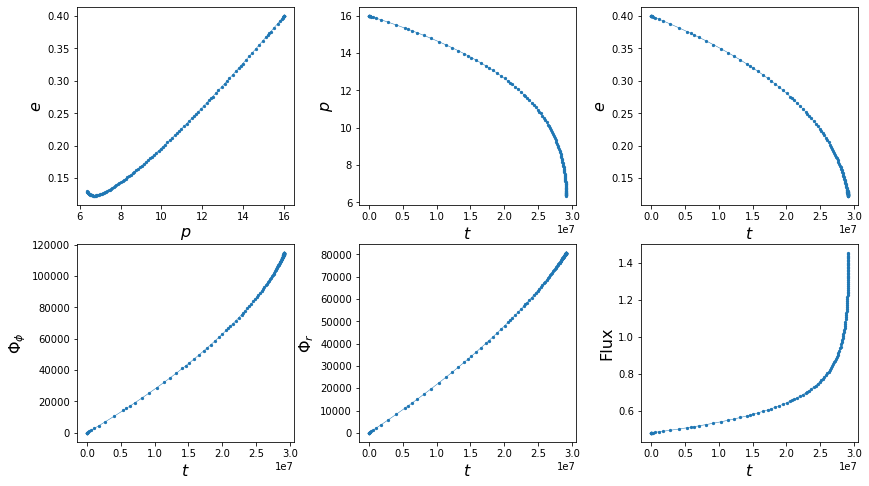

In [5]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'Flux']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r, flux]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y, lw=0.5)
    ax.scatter(x, y, s=5)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

## RomanNet Amplitudes: $A_{lmn}$

To generate the amplitudes, we use a RomanNet ([arXiv:1811.05491](https://arxiv.org/abs/1811.05491)). Roman stands for Reduced Order Modelling with Artificial Neurons. When training a neural network, it can be crucial to hand it data that is distilled to highlight the most pertinent information. A nice tool for doing this is Reduced Order Modeling. Reduced order modelling projects the information with lossless compression down to a lower dimensional space. We take our complex mode amplitude vectors containing 3843 modes and project this down to a real-valued space with 198 values. The neural network is then trained with inputs given by the $p$ and $e$ values and outputs given by the reduced order coefficients ($\alpha_i$):

\begin{equation}
A_{lmn}\in\mathbb{C}^{3843}\xrightarrow{\mathit{ROM}}\alpha_i\in\mathbb{R}^{198}\xrightarrow{\mathit{train}} f(p,e)=\alpha_i
\end{equation}

The neural network itself is extremely simple. It is a fully connected network with a LeakyReLU activation on all layers but the final layer. This means the neural network can be built simply with a sequence of linear matrix multiplications followed by a pass through the activation function. Once the neural network is trained, we will have a set of weights. This is where we will start in this tutorial. 

During online evaluation of the waveform, we perform the reverse process:

\begin{equation}
f(p,e)\xrightarrow{\mathit{eval}}\alpha_i\in\mathbb{R}^{198}\xrightarrow{\mathit{project}}A_{lmn}\in\mathbb{C}^{3843}
\end{equation}

This method has pros and cons:

Pros:

* This is more of a global fit, rather than individual fits to given modes. This generally means storage of less information in memory. If we do individual fits of every mode, the memory necessary to store this information would scale badly with mode content. We are currently working in Schwarzschild Eccentric. As we go to generic Kerr, we expect the number of modes to increase by a factor of $\sim10$.

* Due to its global fit nature, this method is generally faster to evaluate than individual interpolants. 

* Since it is a neural network and a linear projection, this is very suitable to GPUs.

* We expect this method, or methods similar to this, to scale better with dimensionality as we move towards the end goal of generic Kerr orbits. 

Cons:

* For extremely quiet modes, this method can be less accurate. However, as these modes are quiet, this does not result in a significant loss of accuracy in the final waveform. Caution must be taken when using this method to analyze individual mode amplitudes. There is an approximate floor in the amplitude values at $\sim10^{-5}$. For reference, the loudest modes at a given $p$ and $e$ value are usually $\sim0.1-1.0$. (These amplitudes are not scaled for distance.|) 

* Training these neural networks can be more of an art than a science. It takes a lot of trial and error to get this right. 

### Constructing the neural network from trained weights

In [6]:


# prepare to load the weights

path_to_few_dir = romannet.__file__[:-25]

weight_file = fp = "SchwarzschildEccentricInput.hdf5"
check_for_file_download(fp, path_to_few_dir)

weights = []
bias = []
dim1 = []
dim2 = []

# get highest layer number
num_layers = 0

# extract all necessary information from the file
with h5py.File(path_to_few_dir + "few/files/" + weight_file, "r") as fp:
    
    # get basic information
    num_teuk_modes = fp.attrs["num_teuk_modes"]
    transform_factor = fp.attrs["transform_factor"]
    break_index = fp.attrs["break_index"]
    
    # determine layer arrangement 
    for key, value in fp.items():
        if key == "reduced_basis":
            continue

        layer_num = int(key[1:])

        if layer_num > num_layers:
            num_layers = layer_num

    # get weights and bias
    for i in range(1, num_layers + 1):
        temp = {}
        for let in ["w", "b"]:
            mat = fp.get(let + str(i))[:]
            temp[let] = np.asarray(mat)

        weights.append(temp["w"])
        bias.append(temp["b"])
        dim1.append(temp["w"].shape[0])
        dim2.append(temp["w"].shape[1])

    # get the post network transform matrix
    transform_matrix = np.asarray(fp["reduced_basis"])

# activation function
# we use a factor of 0.2 for negative values
def LeakyReLU(x):
    out = (x >= 0.0) * x +  (x < 0.0) * 0.2*x
    return out

# build the neural network
def RomanNet(p, e):
    
    p = np.atleast_1d(p)
    e = np.atleast_1d(e)
    
    # convert from the p coordinate to a special y coordinate
    # see the documentation for more details
    y = p_to_y(p, e)
    
    # prepare input
    x = np.array([y, e])
    
    # basic fully connected network
    for layer_i in range(num_layers):
        
        # linear transformation
        x = np.dot(weights[layer_i].T, x) + bias[layer_i][:, np.newaxis]
        
        # do not want to activate last layer
        if layer_i < num_layers - 1:
            # non-linear activatation
            x = LeakyReLU(x)
            
    # separate real and imaginary
    x = x[:break_index] + 1j * x[break_index:]
    
    # project back to amplitude basis
    out = np.dot(transform_matrix.T, x)/transform_factor
    return out.T
        
    

In [7]:
# test it
p_test = np.array([11.0, 10.0, 10.0])
e_test = np.array([0.2, 0.3, 0.1])

RomanNet(p_test, e_test)

array([[ 6.61875897e-06-9.45689250e-06j,  6.69607160e-06-1.13351771e-05j,
         6.41141133e-06-1.40002164e-05j, ...,
         7.50732732e-05+2.44753603e-05j,  6.73201363e-05-2.51759069e-06j,
        -2.62936078e-07-1.61971784e-05j],
       [-3.03984515e-05+2.23504926e-06j, -3.46638688e-05+2.11040541e-06j,
        -3.99084181e-05+1.67172621e-06j, ...,
         8.48364501e-05-3.51356321e-05j,  1.27022103e-04-6.69149191e-06j,
         9.19366706e-05+1.92716832e-05j],
       [-1.78544871e-06+1.54745952e-05j, -1.96676157e-06+1.75539377e-05j,
         7.20295633e-07+2.05609755e-05j, ...,
        -1.38437626e-05+1.46714870e-05j, -2.75508914e-05+9.37792116e-06j,
         1.12870278e-05+7.38750376e-06j]])

### Produce amplitudes associated with our trajectories

In [8]:
# generate amplitudes with roman net
amps = RomanNet(p, e)

# check against actual code
RomanNetTrue = RomanAmplitude()
amps_check_1 = RomanNetTrue(p, e)

assert np.allclose(amps, amps_check_1)

### Check our RomanNet global fit against accurate values

In [10]:
# get accurate values 
# each mode is fitted with a bicubic spline
BicubicAmps = Interp2DAmplitude()
amps_check_2 = BicubicAmps(p, e)

#### Print vectors

In [11]:
print("romannet:", amps_check_1[0][0:10], "\nBicubic Spline:", amps_check_2[0][0:10])

romannet: [7.69192924e-06-5.39154229e-06j 9.99753291e-06-6.31307778e-06j
 1.35171826e-05-8.06391248e-06j 1.78239290e-05-7.33261441e-06j
 2.14797124e-05-6.31329971e-06j 2.57309168e-05-3.37761067e-06j
 2.89725596e-05+1.17404671e-06j 3.27106651e-05+7.79482012e-06j
 3.64016950e-05+1.64240791e-05j 3.63310870e-05+2.77218824e-05j] 
Bicubic Spline: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


We see if we take a quick examination of our results (a small subset) we see the problem with the global fit. It cannot handle modes with a very small amplitude. Therefore, you might naively think that this method might not work.

#### Compare via the cosine between the vectors

In [12]:
cos = (np.dot(amps_check_2.conj()[0].T, amps_check_1[0]) /
       np.sqrt(np.dot(amps_check_2.conj()[0], amps_check_2[0]) 
               * np.dot(amps_check_1.conj()[0], amps_check_1[0]))).real

print('Cos:', cos)

Cos: 0.9999733790390088


We now see that if we compare the results as a whole, the results match very well. If we look at individual modes that have high power, they are likely to strongly match when the bicubic spline is compared to the RomanNet method. 

## GPU-accelerated Waveform Build: $\sum_{lmn}$

### Quick primer on GPUs

<img src="./GPU_diagram.png" width=950 height=950 />



GPUs run code in parallel in a configuration of grids, blocks, and threads.

* **Threads** are the the actual software units that run the code. Threads run independently of one another. Threads are referenced in code using `threadIdx.x`.
* **Blocks** are an array of threads. This array can be 1, 2, or 3 dimensions. In more than one dimension, thread indices are referenced using `x`, `y`, and `z` (e.g. `threadIdx.z`). Blocks, similar to threads, are referenced using `blockIdx.x`, `blockIdx.y`, or `blockIdx.z`. The size of a block, i.e. the number of threads along a given dimension is given as `blockDim.x`. **Note**: In applications I have worked on, I rarely ever use more than 1 dimension of threads. 
* **Grids** are an array of blocks. This array can be 1, 2, or 3 dimensions. There is no reference for grids as they efffectively represent the entire GPU kernel. The size of a grid, i.e. the number of blocks along a dimension, is determined with `gridDim.x`. 

Organizing your code properly into blocks and threads is a key component of maximizing your efficiency. 

Another equally important aspect to the maximization of efficiency is the proper use of the GPU memory structures. There are three main GPU memory structures to consider (there are a few more but they are for more specific uses). These are global memory, shared memory, and local memory.

* **Global memory** is contained on the host (or off-chip). Global memory is accessible by every block and thread in the entire grid. It contains many GBs of RAM. (The GPUs I use currently, which are Tesla V100s, have ~16GB. The new A100s have 40-80GB.) Because this memory is contained off-chip, it is slow to access. A key to accessing global memory efficiently is to use so-called "memory coalescence." This effectively means that neighboring threads access neighboring addresses in memory. This allows the compiler to make up to 32 memory reads at the same time, rather than 32 separate memory reads. We will see this in a simple case below. 

* **Local memory** is also contained on the host. Local memory consists of any arrays allocated within the kernel specific to each thread. Therefore, this memory is only accessible by the thread it is created on. Usually, around 512 KB are available for local memory for each thread. Since, this memory is off-chip, it is also slow to access. Local memory is, however, always accessed in a memory coalescing manner. 

* **Shared memory** is different. Shared memory is located on-chip. It is, therefore, much faster to read from (~100x faster). Shared memory is accessible by all the threads on a given block. The catch is that only ~48 KB are available for shared memory. Therefore, leveraging shared memory effectively is key to the efficiency of GPU code. 

To sum up, there are two main points to consider when beginning to program on GPUs:

* Layout your grid effectively for your given problem.
* Use memory effectively: leverage the availability of shared memory and read from global memory in a coalescing fashion. 

Some parting thoughts on GPUs:

* For maximal efficiency and stability, I usually code in C++/CUDA so that everything is precompiled and tested. 
* There are python libraries that leverage the power of GPUs. Check out numba, CuPy, PyTorch, Tensorflow, PyCUDA. 
* Lately, I have really focused on writing CPU/GPU agnostic code. This means that the source code is ~99% the same between the two. On the python side I usually sub in CuPy for Numpy. We will see some basic pointers on this below. In C++, I use short compiler directives to make minimal changes.
* Generally speaking it is optimal to store all quantities in a 1 dimensional array when working with GPUs. Let's say you have a two dimensional array that has dimensions (dim1, dim2) and is referenced with (i, j). You can turn this into a 1D array that references each value with (i * dim2 + j). 

### Why are GPUs important for EMRI Waveforms?

The waveform summation is the key bottleneck. This is an operation that is uniquely suited to GPUs. You can see the improvement below.

<img src="./waveform_timing.png" width=700 height=700 />

### Basic example coded in python

We are going to write code in python that will reflect what we will do on the GPU. It will obviously still be on the CPU, but will give you a chance to see how to write some basic GPU code and understand how it works. **Make sure to read the comments in the code.**

We will do two examples. 

#### Multiply two arrays

Here we will multiply two arrays as we would on the GPU. 

In [13]:
# setup our GPU quantities that would come in if we were actually on GPUs. 

NUM_THREADS = 64  # needs to be a multiple of 32
blockDim = NUM_THREADS  # blockDim.x

In [14]:

# this initial piece is a basic of CPU/GPU agnostic code in python
try:
    import cupy as xp
    
except ModuleNotFoundError:
    import numpy as xp

# __global__
def multiply_arrays(array_out, array1, array2, n):
    """
    // what this would like like in CUDA
    
    // if (threadIdx.x + blockDim.x * blockIdx.x >= n) return;
    for (int i = threadIdx.x + blockDim.x * blockIdx.x; i < n; i += blockDim.x * gridDim.x)
    {
        array_out[i] = array1[i] * array2[i];
    }
    """
    # The loops here are to simulate the GPU. 
    # In reality the GPU will run all threads and blocks in parallel
    
    # begin simulation
    for block in range(num_blocks):
        for thread in range(NUM_THREADS):
    # end simulation
    
            # get the overall index in the grid
            # based on the thread and block
            i = thread + block * blockDim
        
            # since the GPU runs threads in parallel
            # we need to make sure the GPU does not index a value
            # on the last block that goes over the array length
            if i >= n:
                continue
                
            # use our index to get values out of the array
            # notice this simple statement uses memory coalescence
            # neighboring threads will have consecutive indices
            # therefore, they will access consecutive addresses in each array
            array_out[i] = array1[i] * array2[i]
            

length = int(2 ** 14)

# initialize arrays
array1 = xp.random.rand(length)
array2 = xp.random.rand(length)
    
# prepare output array
array_out = xp.zeros_like(array1)

# get the number of blocks
# the number of blocks multiplied by the number of threads per block
# must be greater than the length of the array 
num_blocks = int(np.ceil((length + NUM_THREADS -1)/NUM_THREADS))

# this would actually be called as
"""
multiply_arrays<<<num_blocks, NUM_THREADS>>>(array_out, array1, array2, length);
cudaDeviceSynchronize();
"""

multiply_arrays(array_out, array1, array2, length)

# confirm it
assert np.allclose(array_out, array1 * array2)

#### Linear Interpolation to scale up an array 

For our second example it will be a bit more complicated. This way we can see how to use shared memory. 

Here we will scale up the size of an array using linear interpolation. The key here is that we need every block to read in the original array to shared memory. From there, we perform the interpolation. This allows us to achieve memory coalescence with all global reads and ensure that all reads when actually interpolating are done from shared memory. 

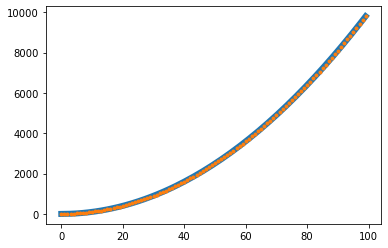

In [15]:
# in CUDA, when you statically allocate shared arrays,
# you cannot use a variable length
# therefore, in C++/CUDA you need to declare a max value up front

#define MAX_INPUT 1000

def linear_interpolation(array_out, array_in, n_out, n_in, dx_out, dx_in):
    
    # we want to read in to shared memory
    # want to do this with memory coalescence
    # since this is only on a specific block
    # we need to use only the threads on this block
    
    """
    // the below simulated code block in CUDA would look like this:
        
    // in CUDA, you have to declare shared arrays
    
    __shared__ double shared_array_in[MAX_INPUT];
    
    
    for (int i = threadIdx.x; i < n_in; i += blockDim.x)
    {
        // memory coalescence only needed from array_in (global memory)
        shared_array_in[i] = array_in[i];
    }
    
    // we need to make sure the threads all finish this operation before we move on
    // Therefore, we force the threads to synchronize
    
    __syncthreads();
    
    """
    
    
    # we will just do the following to simulate in python easily
    shared_array_in = xp.zeros(n_in)
    
    for thread in range(NUM_THREADS):
        i = thread 
        
        # this while statement simulates the above commented loop
        while (i < n_in):
            # here is the memory coalesced reads
            shared_array_in[i] = array_in[i]
            
            # just for simulation
            i += blockDim
        
        
    """
    // this is what the below would really like it in CUDA
    // if (threadIdx.x + blockDim.x * blockIdx.x >= n_out) return;
    for (int i = threadIdx.x + blockDim.x * blockIdx.x; i < n_out; i += blockDim.x * gridDim.x)
    {
        // get the new out value assuming equal spacing
        double x_new = dx_out * i;
            
        // get index of the point in the original array below the new point
        int ind_in = (int) (x_new / dx_in);
        
        // get the below x value
        double x_old = ind_in * dx_in;

        // slope of segment
        double m = (shared_array_in[ind_in + 1] - shared_array_in[ind_in])/dx_in;

        // interpolate
        double new_value = m * (x_new - x_old) + shared_array_in[ind_in];
        array_out[i] = new_value;
    }
    
    """
    # The loops here are to simulate the GPU. 
    # In reality the GPU will run all threads and blocks in parallel
    
    # begin simulation
    for block in range(num_blocks):
        for thread in range(NUM_THREADS):
    # end simulation
    
            # get the overall index in the grid
            # based on the thread and block
            i = thread + block * blockDim
        
            # since the GPU runs threads in parallel
            # we need to make sure the GPU does not index a value
            # on the last block that goes over the array length
            if i >= n_out:
                continue
                
            x_new = dx_out * i
            
            ind_in = int(x_new / dx_in)
            x_old = ind_in * dx_in
            
            m = (shared_array_in[ind_in + 1] - shared_array_in[ind_in])/dx_in
            
            new_value = m * (x_new - x_old) + shared_array_in[ind_in]
            array_out[i] = new_value
    

# original length
length_in = 100

# prepare input arrays
x_in = xp.arange(length_in)
y_in = (x_in ** 2).astype(xp.float64)

# set length out
length_out = int(2 ** 14)

# setup the new x_values
x_new = xp.linspace(x_in[0], x_in[-1], length_out + 1)[:-1]

# change in original x values
dx_in = 1.0

# we will actually only use the spacing to find new points
dx_out = x_new[1] - x_new[0]
    
y_out = xp.zeros(length_out)

num_blocks = int(np.ceil((length_out + NUM_THREADS -1)/NUM_THREADS))

# this would actually be called as
# linear_interpolation<<<num_blocks, NUM_THREADS>>>(y_out, y_in, length_out, length_in, dx_out, dx_in);
# cudaDeviceSynchronize();
linear_interpolation(y_out, y_in, length_out, length_in, dx_out, dx_in)

# confirm it
plt.plot(x_new, y_out, lw=6, label='out')
plt.plot(x_in, y_in, '.', label='in')

### Comment on CPU/GPU Agnostic code in C++/CUDA and Python

Making CPU/GPU agnostic code consists of 3 main parts: 

* Sub CuPy for NumPy
* Compiler directives in C++/CUDA
* Easy transition from Python to C++ through an augmented Cython process

Above, we saw an example of how to deal with the Python side. The Cython functionality is effectively a decorator function that gets the pointer of a Numpy or Cupy array and sends that into the C++ code. Below is a basic example of how to use basic compiler directives to make your code more CPU/GPU agnostic.

**Note**: I generally argue that we should build codes for GPUs and then adapt them to CPUs, not the other way around which is the typical direction. In my experience, the CPU codes adapted from GPU codes are just as fast or within a small percentage of the speed of CPU designed codes. And, generally, it is much harder to optimize going from CPU->GPU rather than GPU->CPU. 

<img src="./code_block_example.png" width=700 height=700 />

## Future Plans

* Build fast trajectories in Kerr under the NIT framework
* Generate amplitudes in Kerr regime
* Further analyze how to determine best methods for mode content inclusion

We need your help! If anyone is interested in working on these types of issues, please let myself or any of my collaborators (listed above) know!